# Image Captioning with Flickr30k

An image captioning pipeline using 

-  Pre-trained ResNet50 for feature extraction 
-  LSTM-based Decoder for caption generation
-  The model is trained on the Flickr30k dataset.

## Imports and Setup

In [17]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import random
import re
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1: Feature Extraction Pipeline
Used a pretrained ResNet50 to convert images into 2048-dimensional feature vectors and cache them.

In [18]:
def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    # Fallback for local testing or different structure
    IMAGE_DIR = './flickr30k_images' 
    if not os.path.exists(IMAGE_DIR):
        print("Warning: Could not find Flickr30k image directory.")

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

if not os.path.exists(OUTPUT_FILE):
    print("Extracting features...")
    model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model_resnet = nn.Sequential(*list(model_resnet.children())[:-1]) # Remove final FC layer
    model_resnet = nn.DataParallel(model_resnet).to(device)
    model_resnet.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    dataset = FlickrDataset(IMAGE_DIR, transform)
    loader = DataLoader(dataset, batch_size=128, num_workers=4)

    features_dict = {}
    with torch.no_grad():
        for imgs, names in tqdm(loader, desc="Extracting Features"):
            feats = model_resnet(imgs.to(device)).view(imgs.size(0), -1)
            for i, name in enumerate(names):
                features_dict[name] = feats[i].cpu().numpy()

    with open(OUTPUT_FILE, 'wb') as f:
        pickle.dump(features_dict, f)
    print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")
else:
    print(f"{OUTPUT_FILE} already exists. Loading features...")
    with open(OUTPUT_FILE, 'rb') as f:
        features_dict = pickle.load(f)
    print(f"Loaded {len(features_dict)} features.")

Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
flickr30k_features.pkl already exists. Loading features...
Loaded 31783 features.


## Part 2: Vocabulary & Text Pre-Processing
Loading the captions and building a vocabulary.

In [19]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        # Handle non-string (float/NaN) inputs safely
        if not isinstance(text, str):
            text = str(text) if text is not None else ""
        return re.findall(r"\w+", text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] = frequencies.get(word, 0) + 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"])
            for token in tokenized_text
        ]

def find_caption_file():
    for root, dirs, files in os.walk('/kaggle/input'):
        if 'captions.txt' in files:
            return os.path.join(root, 'captions.txt')
    return None

CAPTION_FILE = find_caption_file()
if not CAPTION_FILE:
    CAPTION_FILE = 'captions.txt' # Fallback

df = pd.read_csv(CAPTION_FILE)
# Some versions of flicker dataset use '|' as separator or have different column names
if 'image,caption' in df.columns or df.shape[1] == 1:
    df = pd.read_csv(CAPTION_FILE, sep='|' if '|' in open(CAPTION_FILE).read(100) else ',')

df.columns = [c.strip() for c in df.columns]
if 'comment' in df.columns and 'image_name' in df.columns:
    df = df.rename(columns={'image_name': 'image', 'comment': 'caption'})

# Drop any rows with missing captions to avoid float/NaN errors
df = df.dropna(subset=['caption'])

print(f"Loaded {len(df)} captions.")

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(df['caption'].tolist())
print(f"Vocabulary Size: {len(vocab)}")

Loaded 158914 captions.
Vocabulary Size: 7654


## Part 3: The Seq2Seq Architecture
Building the Encoder and Decoder using PyTorch.

In [20]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        # The prompt specifies: A Linear layer that projects 2048-dim vector to hidden_size
        self.projection = nn.Linear(2048, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, features):
        return self.dropout(self.relu(self.projection(features)))

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        """
        features: shape (batch, embed_size) - initial hidden state projection
        captions: shape (batch, seq_len) - word indices
        """
        # Remove <EOS> from captions for input
        embeddings = self.dropout(self.embed(captions[:, :-1]))
        
        # The prompt says: Initial Hidden State is the output of your Encoder
        # We'll use the Encoder output to initialize both h and c for the LSTM
        # Shape: (num_layers, batch, hidden_size)
        initial_h = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        initial_c = torch.zeros_like(initial_h)
        
        outputs, _ = self.lstm(embeddings, (initial_h, initial_c))
        outputs = self.linear(outputs)
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CNNtoRNN, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Part 4: Data Pipeline and Training Setup

In [21]:
class CaptionDataset(Dataset):
    def __init__(self, df, features_dict, vocab):
        self.df = df
        self.features_dict = features_dict
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['image']
        caption = row['caption']
        
        feature = self.features_dict[img_id]
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(str(caption))
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return torch.tensor(feature), torch.tensor(numericalized_caption)

def collate_fn(batch):
    features = [item[0].unsqueeze(0) for item in batch]
    features = torch.cat(features, dim=0)
    captions = [item[1] for item in batch]
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<PAD>"])
    return features, captions

# Split data
unique_images = df['image'].unique()
random.seed(42)
random.shuffle(unique_images)

train_split = int(0.9 * len(unique_images))
train_imgs = unique_images[:train_split]
val_imgs = unique_images[train_split:]

train_df = df[df['image'].isin(train_imgs)]
val_df = df[df['image'].isin(val_imgs)]

train_dataset = CaptionDataset(train_df, features_dict, vocab)
val_dataset = CaptionDataset(val_df, features_dict, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2)

## Part 5: Training Loop

In [22]:
embed_size = 512
hidden_size = 512
vocab_size = len(vocab)
num_epochs = 16
learning_rate = 3e-4

model = CNNtoRNN(embed_size, hidden_size, vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for imgs, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, captions = imgs.to(device), captions.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs, captions)
        
        # Targets are captions shifting left one
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for imgs, captions in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, captions = imgs.to(device), captions.to(device)
            outputs = model(imgs, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.43it/s] 


Epoch [1/16], Train Loss: 4.0796, Val Loss: 3.5302


Epoch 2/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.46it/s] 


Epoch [2/16], Train Loss: 3.4084, Val Loss: 3.2532


Epoch 3/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.17it/s] 


Epoch [3/16], Train Loss: 3.1809, Val Loss: 3.1229


Epoch 4/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.01it/s] 


Epoch [4/16], Train Loss: 3.0413, Val Loss: 3.0504


Epoch 5/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.75it/s] 


Epoch [5/16], Train Loss: 2.9419, Val Loss: 2.9994


Epoch 6/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.65it/s] 


Epoch [6/16], Train Loss: 2.8652, Val Loss: 2.9672


Epoch 7/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.76it/s] 


Epoch [7/16], Train Loss: 2.8032, Val Loss: 2.9433


Epoch 8/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.66it/s] 


Epoch [8/16], Train Loss: 2.7497, Val Loss: 2.9294


Epoch 9/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.69it/s] 


Epoch [9/16], Train Loss: 2.7040, Val Loss: 2.9164


Epoch 10/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.13it/s] 


Epoch [10/16], Train Loss: 2.6632, Val Loss: 2.9086


Epoch 11/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.88it/s] 


Epoch [11/16], Train Loss: 2.6271, Val Loss: 2.9014


Epoch 12/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.70it/s] 


Epoch [12/16], Train Loss: 2.5931, Val Loss: 2.8985


Epoch 13/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 96.14it/s] 


Epoch [13/16], Train Loss: 2.5638, Val Loss: 2.8925


Epoch 14/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.66it/s] 


Epoch [14/16], Train Loss: 2.5359, Val Loss: 2.8965


Epoch 15/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 95.47it/s] 


Epoch [15/16], Train Loss: 2.5100, Val Loss: 2.8914


Epoch 16/16 [Val]: 100%|██████████| 249/249 [00:02<00:00, 94.82it/s] 

Epoch [16/16], Train Loss: 2.4852, Val Loss: 2.9004


## Part 6: Inference (Greedy and Beam Search)

In [23]:
def greedy_search(model, image_feat, vocab, max_len=20):
    model.eval()
    result_caption = []
    
    with torch.no_grad():
        feat = model.encoder(image_feat.unsqueeze(0).to(device))
        h = feat.unsqueeze(0)
        c = torch.zeros_like(h)
        
        # Initial word <SOS>
        x = torch.tensor([vocab.stoi["<SOS>"]]).to(device)
        
        for _ in range(max_len):
            embeds = model.decoder.embed(x).unsqueeze(1)
            output, (h, c) = model.decoder.lstm(embeds, (h, c))
            output = model.decoder.linear(output.squeeze(1))
            predicted = output.argmax(1)
            
            token = vocab.itos[predicted.item()]
            if token == "<EOS>":
                break
                
            result_caption.append(token)
            x = predicted
            
    return " ".join(result_caption)

def beam_search(model, image_feat, vocab, beam_width=3, max_len=20):
    model.eval()
    with torch.no_grad():
        feat = model.encoder(image_feat.unsqueeze(0).to(device))
        h = feat.unsqueeze(0)
        c = torch.zeros_like(h)
        
        start_token = vocab.stoi["<SOS>"]
        # (score, sentence, last_word_id, hidden_state, cell_state)
        beams = [(0.0, [], start_token, h, c)]
        
        for _ in range(max_len):
            new_beams = []
            for score, sent, last_word, h_prev, c_prev in beams:
                if last_word == vocab.stoi["<EOS>"]:
                    new_beams.append((score, sent, last_word, h_prev, c_prev))
                    continue
                
                x = torch.tensor([last_word]).to(device)
                embeds = model.decoder.embed(x).unsqueeze(1)
                output, (h_next, c_next) = model.decoder.lstm(embeds, (h_prev, c_prev))
                output = torch.softmax(model.decoder.linear(output.squeeze(1)), dim=1)
                
                top_probs, top_idxs = output.topk(beam_width)
                
                for i in range(beam_width):
                    new_score = score - torch.log(top_probs[0][i]).item()
                    new_sent = sent + [vocab.itos[top_idxs[0][i].item()]]
                    new_beams.append((new_score, new_sent, top_idxs[0][i].item(), h_next, c_next))
            
            beams = sorted(new_beams, key=lambda x: x[0])[:beam_width]
            
            if all(b[2] == vocab.stoi["<EOS>"] for b in beams):
                break
                
        best_sent = beams[0][1]
        if "<EOS>" in best_sent:
            best_sent = best_sent[:best_sent.index("<EOS>")]
        return " ".join(best_sent)

## Deliverables 1 & 3: Quantitative Evaluation & Caption Examples

--- Caption Examples ---


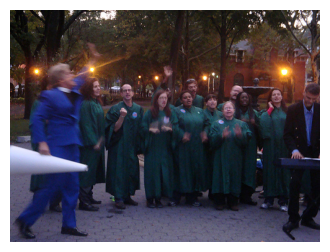

Image: 3970504937.jpg
Ground Truth:  A man in a blue suit walks in front of a group of choir singers dressed in green .
Generated: a group of people are standing in front of a building
--------------------------------------------------


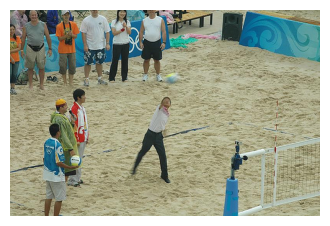

Image: 2845913086.jpg
Ground Truth:  A man hits a volleyball on a beach volleyball court while spectators look on .
Generated: a group of children playing in a sand castle
--------------------------------------------------


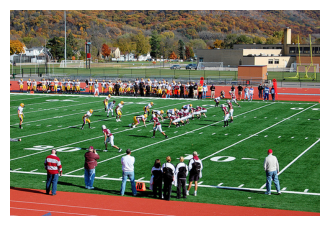

Image: 4045084364.jpg
Ground Truth:  A football team is playing football while people are watching from the sidelines .
Generated: a soccer game is being played on the field
--------------------------------------------------


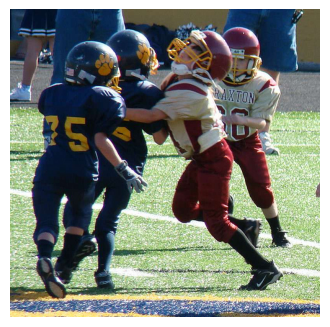

Image: 2947172114.jpg
Ground Truth:  Four children , in uniforms of two different teams , are playing football .
Generated: a football player in a white uniform is tackling a player in a white uniform
--------------------------------------------------


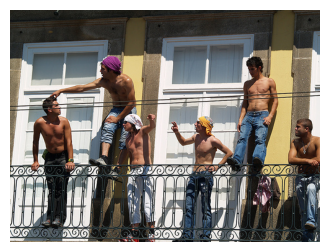

Image: 1297871927.jpg
Ground Truth:  Six shirtless men are standing outside leaning on or standing near a fence .
Generated: a group of people are standing on a beach
--------------------------------------------------


Evaluating BLEU: 100%|██████████| 100/100 [00:01<00:00, 62.89it/s]

BLEU-4 Score: 0.1889
Precision: 0.4809
Recall: 0.4329
F1-Score: 0.4444


In [24]:
# Qualitative Evaluation
print("--- Caption Examples ---")
random_indices = random.sample(range(len(val_imgs)), 5)
for idx in random_indices:
    img_name = val_imgs[idx]
    true_captions = df[df['image'] == img_name]['caption'].tolist()
    feat = torch.tensor(features_dict[img_name])
    
    generated = greedy_search(model, feat, vocab)
    
    # Display image (if possible in kaggle)
    try:
        img_path = os.path.join(IMAGE_DIR, img_name)
        plt.figure(figsize=(4, 4))
        plt.imshow(Image.open(img_path))
        plt.axis('off')
        plt.show()
    except:
        pass
        
    print(f"Image: {img_name}")
    print(f"Ground Truth: {true_captions[0]}")
    print(f"Generated: {generated}")
    print("-" * 50)

# Quantitative Evaluation
hypotheses = []
references = []

for img_name in tqdm(val_imgs[:100], desc="Evaluating BLEU"):
    true_captions = df[df['image'] == img_name]['caption'].tolist()
    feat = torch.tensor(features_dict[img_name])
    generated = greedy_search(model, feat, vocab)
    
    hypotheses.append(vocab.tokenize(generated))
    references.append([vocab.tokenize(tc) for tc in true_captions])

bleu4 = corpus_bleu(references, hypotheses)
print(f"BLEU-4 Score: {bleu4:.4f}")

# Token-level Precision/Recall/F1
def calculate_metrics(refs, hyps):
    precisions = []
    recalls = []
    f1s = []
    for r_list, h in zip(refs, hyps):
        # Use only the first reference for simplicity or max across all
        best_f1 = 0
        best_p = 0
        best_r = 0
        for r in r_list:
            common = Counter(h) & Counter(r)
            num_common = sum(common.values())
            p = num_common / len(h) if len(h) > 0 else 0
            r_val = num_common / len(r) if len(r) > 0 else 0
            f = 2 * p * r_val / (p + r_val) if (p + r_val) > 0 else 0
            if f > best_f1:
                best_f1, best_p, best_r = f, p, r_val
        precisions.append(best_p)
        recalls.append(best_r)
        f1s.append(best_f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

p, r, f1 = calculate_metrics(references, hypotheses)
print(f"Precision: {p:.4f}")
print(f"Recall: {r:.4f}")
print(f"F1-Score: {f1:.4f}")

## Deliverable 2: Loss Curve

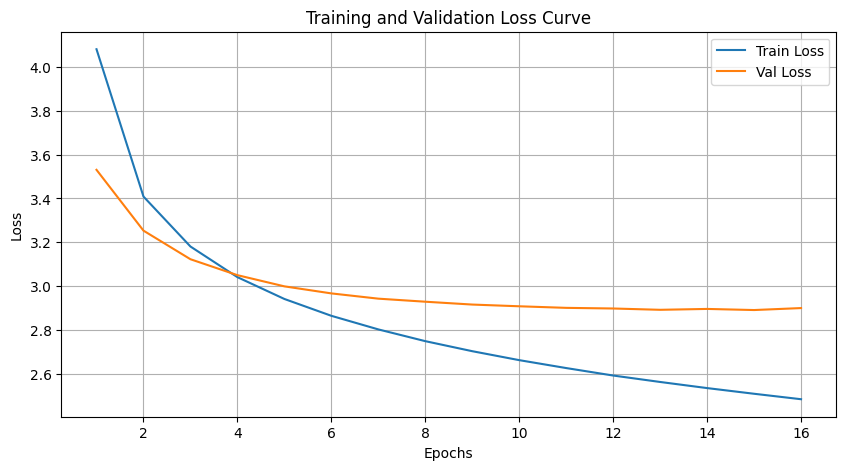

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# --- GRADIO APP FOR DEMO ---
!pip install -q gradio nest_asyncio --no-warn-conflicts
import gradio as gr
import nest_asyncio
from PIL import Image
import torch
from torchvision import models, transforms

# Fix for 'RuntimeError: bound to a different event loop' in notebooks
nest_asyncio.apply()

print(f"Using device for inference: {device}")

# Close any existing apps
gr.close_all()

# 1. Setup Feature Extractor
resnet_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_extractor = torch.nn.Sequential(*list(resnet_extractor.children())[:-1]).to(device)
resnet_extractor.eval()

inf_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def get_caption(img):
    if img is None: return "No image uploaded."
    try:
        img_t = inf_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feats = resnet_extractor(img_t).view(1, -1)
            caption = greedy_search(model, feats.squeeze(0), vocab)
        return caption
    except Exception as e:
        return f"Error during inference: {str(e)}"

demo = gr.Interface(
    fn=get_caption,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Textbox(label="Generated Caption"),
    title="📸 Visionary AI - Image Captioning Demo",
    description="This demo uses a ResNet50 + LSTM architecture trained on Flickr30k.",
    theme="glass"
)

demo.launch(share=True)

Using device for inference: cuda
Closing server running on port: 7860
Closing server running on port: 7861
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://84730c7c6e00aac0fe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",